# Understanding RealNVP: Real-valued Non-Volume Preserving Flows

Imagine transforming a simple distribution (like a Gaussian) into a complex one (like our Swiss Roll) through a series of invertible transformations. This is exactly what RealNVP does! Unlike diffusion models that gradually add noise, or flow matching that learns velocity fields, RealNVP learns direct invertible mappings between simple and complex distributions.

**Key Differences from Other Methods:**
- **Diffusion Models**: Add/remove noise gradually over many steps (typically 1000+)
- **Flow Matching**: Learn continuous velocity fields for transforming distributions
- **RealNVP**: Uses coupling layers for exact, invertible transformations in a single pass

## Core Idea: Coupling Layers

The fundamental building block of RealNVP is the coupling layer. Each layer:
1. Splits input dimensions into two parts using a binary mask
2. Keeps one part unchanged
3. Transforms the other part using the unchanged part as context

The transformation is designed to be both invertible and have an easily computable Jacobian determinant:

$$y_{1:d} = x_{1:d} \odot \text{mask}$$
$$y_{d+1:D} = (1-\text{mask}) \odot (x_{d+1:D} \cdot \exp(s(x_{1:d})) + t(x_{1:d}))$$

where $s(.)$ and $t(.)$ are scale and translation networks.

## Why This Works: Change of Variables Formula

The key to training normalizing flows like RealNVP is the change of variables formula:

$$\log p_X(x) = \log p_Z(f(x)) + \log \left|\det\left(\frac{\partial f(x)}{\partial x}\right)\right|$$

where:
- $p_X(x)$ is the density we want to learn
- $p_Z(z)$ is a simple base density (like N(0,I))
- $f$ is our invertible transformation
- The last term is the log determinant of the Jacobian

The coupling layer design ensures this determinant is easily computable:

$$\log \left|\det\left(\frac{\partial f(x)}{\partial x}\right)\right| = \sum_{i=d+1}^D s_i(x_{1:d})$$

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## Swiss Roll Data Generation

We'll use the same Swiss Roll data generator from our previous examples for consistency.

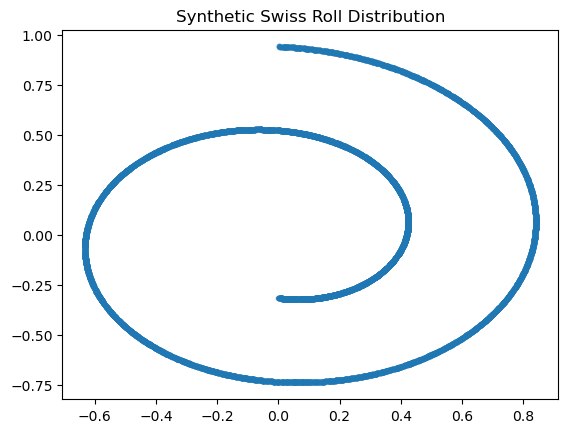

In [7]:
def generate_swiss_roll(n_samples=1000):
    """
    Generate 2D Swiss Roll data points.

    Args:
        n_samples: Number of points to generate.

    Returns:
        torch.Tensor of shape (n_samples, 2)
    """
    t = 1.5 * np.pi * (1 + 2 * torch.rand(n_samples))
    x = t * torch.cos(t)
    y = t * torch.sin(t)
    data = torch.stack([x, y], dim=1) / 15.0  # Scale down the data
    return data


# Example visualization
data = generate_swiss_roll(n_samples=10000)
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, s=10)
plt.title("Synthetic Swiss Roll Distribution")
plt.show()

## Scale-Translation Network

The core of RealNVP's transformation is its Scale-Translation network. This network takes half of the dimensions as input and outputs transformation parameters for the other half.

**Network Architecture:**
- Input: $x_{1:d}$ (masked dimensions)
- Output: $(s, t)$ where:
  - $s$: scaling factor (log-scale)
  - $t$: translation vector
  
**Design Considerations:**
1. **Expressivity**: Multiple layers allow learning complex relationships
2. **Stability**: tanh activation on scale prevents extreme transformations
3. **Output Dimension**: Must match the dimensionality of transformed features

The network implements the mapping:
$$h_\theta: \mathbb{R}^d \rightarrow \mathbb{R}^{2(D-d)}$$
where $\theta$ represents the network parameters.

In [8]:
class ScaleTranslateNet(nn.Module):
    """Network to predict scale and translation parameters."""

    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        # Define a simple MLP with two hidden layers
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, out_features),
        )

    def forward(self, x):
        return self.net(x)

## Coupling Layer: The Heart of RealNVP

The coupling layer implements an affine transformation that is:
1. **Invertible**: We can exactly recover inputs from outputs
2. **Has Tractable Jacobian**: The determinant is easy to compute
3. **Expressive**: Can learn complex transformations when stacked

**Mathematical Formulation:**

Let $\mathbf{x} \in \mathbb{R}^D$ be our input. A coupling layer:

1. **Splits** the input using a binary mask $\mathbf{m}$:
   $$\mathbf{x}_1 = \mathbf{x} \odot \mathbf{m}$$
   $$\mathbf{x}_2 = \mathbf{x} \odot (1-\mathbf{m})$$

2. **Transforms** $\mathbf{x}_2$ conditioned on $\mathbf{x}_1$:
   $$\mathbf{y}_1 = \mathbf{x}_1$$
   $$\mathbf{y}_2 = \mathbf{x}_2 \odot \exp(s(\mathbf{x}_1)) + t(\mathbf{x}_1)$$

3. **Jacobian determinant** is simply:
   $$\log |\det J| = \sum_i s_i(\mathbf{x}_1)$$

**TODO:** Implement the forward transformation in the coupling layer.  
The transformation should be: y = x_masked + (1 - mask) * (x * exp(s) + t)
where s and t are the scale and translation predicted by the network.

In [9]:
class CouplingLayer(nn.Module):
    """A single coupling layer in RealNVP."""

    def __init__(self, dim, hidden_dim, mask):
        super().__init__()
        self.dim = dim
        self.mask = mask  # Binary mask indicating which dimensions remain unchanged
        # Network outputs both scale and translation
        self.st_net = ScaleTranslateNet(dim, hidden_dim, dim * 2)

    def forward(self, x):
        """
        Forward pass implementing the affine coupling transform.

        Args:
            x: Input tensor of shape (batch_size, dim)

        Returns:
            y: Transformed tensor
            log_det_J: Log determinant of the Jacobian
        """
        # Get masked input (unchanged part)
        mask = self.mask.to(x.device)
        x_masked = x * mask

        # Get scale and translation from network
        st = self.st_net(x_masked)
        s, t = st.chunk(2, dim=1)
        s = torch.tanh(s)  # Stabilize the scale

        # Implement the forward transformation
        # 1. Keep the masked dimensions unchanged
        # 2. Transform unmasked dimensions using scale and translation
        # 3. Compute log determinant of Jacobian
        # Hint: y = x_masked + (1 - mask) * (x * exp(s) + t)
        #       log_det_J = sum((1 - mask) * s, dim=1)

        # raise NotImplementedError(
        #     "Implement the forward transformation in CouplingLayer"
        # )

        y = x_masked + (1 - mask) * (x * torch.exp(s) + t)
        log_det_J = torch.sum((1 - mask) * s, dim=1)
        return y, log_det_J

    def inverse(self, y):
        """Inverse transform."""
        mask = self.mask.to(y.device)
        y_masked = y * mask
        st = self.st_net(y_masked)
        s, t = st.chunk(2, dim=1)
        s = torch.tanh(s)

        # Invert the affine transformation
        x = y_masked + (1 - mask) * ((y - t) * torch.exp(-s))
        log_det_J = -((1 - mask) * s).sum(dim=1)
        return x, log_det_J

## Complete RealNVP Model

The full RealNVP model stacks multiple coupling layers with alternating masks. This ensures that:
1. All dimensions can be transformed
2. Information can flow between all dimensions
3. The transformation remains invertible

**Architecture:**
$$f = f_K \circ f_{K-1} \circ ... \circ f_1$$

where each $f_k$ is a coupling layer with its own mask.

**Log-likelihood Computation:**
For a base distribution $p_Z(\mathbf{z})$ (typically $\mathcal{N}(0,I)$), the log-likelihood is:
$$\log p_X(\mathbf{x}) = \log p_Z(f(\mathbf{x})) + \sum_{k=1}^K \log |\det J_k|$$

This can be efficiently computed since each coupling layer's Jacobian determinant is tractable.

In [10]:
class RealNVP(nn.Module):
    """Complete RealNVP model with multiple coupling layers."""

    def __init__(self, dim, hidden_dim, num_coupling_layers):
        super().__init__()
        self.dim = dim

        # Create alternating binary masks
        masks = []
        for i in range(num_coupling_layers):
            if i % 2 == 0:
                mask = torch.tensor([1 if j < dim // 2 else 0 for j in range(dim)])
            else:
                mask = torch.tensor([0 if j < dim // 2 else 1 for j in range(dim)])
            masks.append(mask)

        # Stack coupling layers
        self.coupling_layers = nn.ModuleList(
            [CouplingLayer(dim, hidden_dim, mask) for mask in masks]
        )

    def forward(self, x):
        """Transform data x to latent z."""
        log_det_J = 0
        for layer in self.coupling_layers:
            x, ld = layer(x)
            log_det_J += ld
        return x, log_det_J

    def inverse(self, z):
        """Transform latent z back to data x."""
        log_det_J = 0
        for layer in reversed(self.coupling_layers):
            z, ld = layer.inverse(z)
            log_det_J += ld
        return z, log_det_J

## Training the RealNVP Model

The training process optimizes the negative log-likelihood (NLL) of the data. For a batch of samples, we:

1. **Compute Base Density**: For standard normal base distribution:
   $$\log p_Z(\mathbf{z}) = -\frac{1}{2}\sum_i (z_i^2 + \log(2\pi))$$

2. **Apply Change of Variables**:
   $$\log p_X(\mathbf{x}) = \log p_Z(f(\mathbf{x})) + \log |\det J_f(\mathbf{x})|$$

3. **Minimize Loss**:
   $$\mathcal{L} = -\mathbb{E}_{\mathbf{x}\sim p_\text{data}}[\log p_X(\mathbf{x})]$$

Unlike diffusion models that require multiple denoising steps, RealNVP performs exact likelihood computation in a single pass.

In [ ]:
def train_realnvp(n_steps=10000, batch_size=128, lr=1e-3):
    """Train the RealNVP model on Swiss Roll data."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize model
    dim = 2
    hidden_dim = 128
    num_coupling_layers = 6
    model = RealNVP(dim, hidden_dim, num_coupling_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []
    pbar = tqdm(range(n_steps), desc="Training RealNVP")

    for step in pbar:
        # Get batch of Swiss Roll data
        x = generate_swiss_roll(batch_size).to(device)

        # Forward pass to get latent z
        z, log_det_J = model(x)

        # Compute log likelihood
        log_pz = -0.5 * (z**2 + np.log(2 * np.pi)).sum(dim=1)
        log_px = log_pz + log_det_J
        loss = -log_px.mean()

        # Optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        pbar.set_postfix({"loss": loss.item()})

    return model, losses, device


# Train the model
model, losses, device = train_realnvp()

# Plot training loss
plt.plot(losses)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

Training RealNVP:  14%|█▍        | 1386/10000 [00:28<03:18, 43.33it/s, loss=-0.63]   

## Generation and Visualization

To generate samples from the trained RealNVP model, we:

1. **Sample from Base Distribution**:
   $$\mathbf{z} \sim \mathcal{N}(0, I)$$

2. **Apply Inverse Transform**:
   $$\mathbf{x} = f^{-1}(\mathbf{z})$$

The inverse transform is exact and computationally efficient, unlike diffusion models that require multiple steps.

**Quality Metrics to Consider:**
1. **Coverage**: Does the model capture the full Swiss Roll shape?
2. **Density**: Are samples distributed similarly to the training data?
3. **Smoothness**: Is the learned transformation continuous?

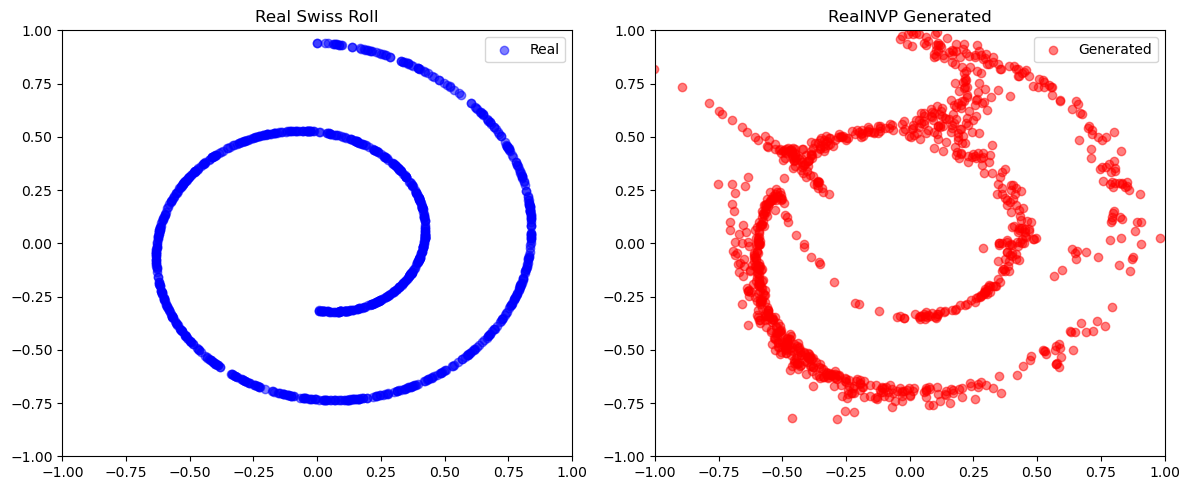

In [12]:
def visualize_samples(model, n_samples=1000, device="cpu"):
    """Generate and visualize samples from the RealNVP model."""
    with torch.no_grad():
        # Sample from base distribution
        z = torch.randn(n_samples, 2).to(device)
        # Transform to data space
        x_gen, _ = model.inverse(z)
        x_gen = x_gen.cpu()

    # Get real data for comparison
    x_real = generate_swiss_roll(n_samples)

    # Plot
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(x_real[:, 0], x_real[:, 1], c="blue", alpha=0.5, label="Real")
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.title("Real Swiss Roll")
    plt.legend()
    # plt.axis('equal')

    plt.subplot(1, 2, 2)
    plt.scatter(x_gen[:, 0], x_gen[:, 1], c="red", alpha=0.5, label="Generated")
    plt.title("RealNVP Generated")
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.legend()
    # plt.axis('equal')

    plt.tight_layout()
    plt.show()


# Visualize samples
visualize_samples(model, device=device)